<a href="https://colab.research.google.com/github/Himangi-77/excelR-assignments/blob/main/ASSIGNMENT18_FORECASTING_COCACOLASALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots

In [4]:
series = pd.read_excel('/content/CocaCola_Sales_Rawdata (1).xlsx', parse_dates=True)
series.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
series.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


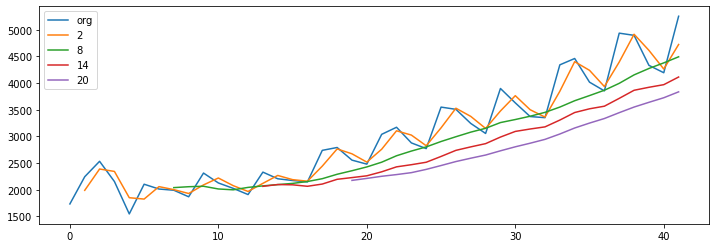

In [6]:
plt.figure(figsize=(12,4))
series.Sales.plot(label='org')
for i in range(2,24,6):
  series['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

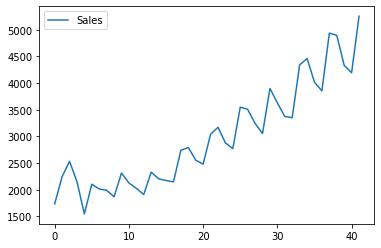

In [7]:
series.plot()
plt.show()

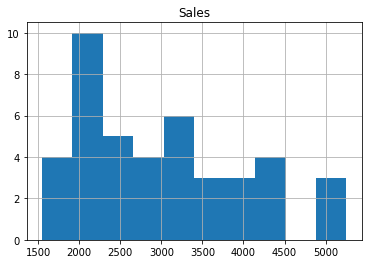

In [8]:
series.hist()
plt.show()

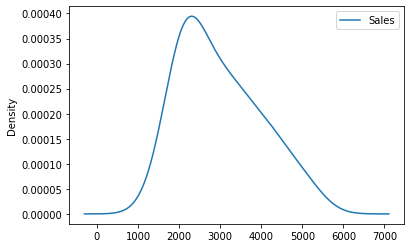

In [9]:
series.plot(kind='kde')
plt.show()

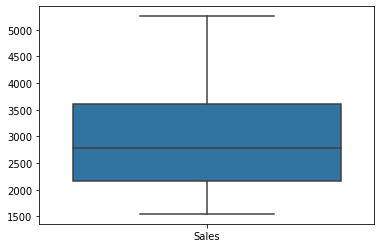

In [10]:
sns.boxplot(data=series)

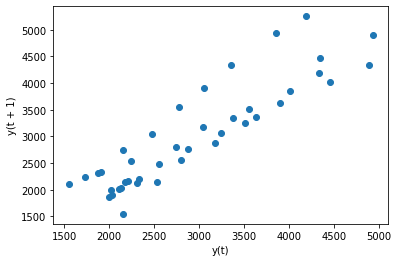

In [11]:
lag_plot(series['Sales'])

**TIME SERIES DECOMPOSITION PLOT**

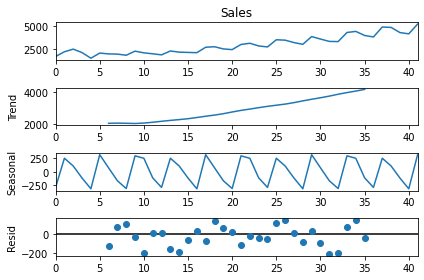

In [12]:
decompose_ts_add = seasonal_decompose(series.Sales,period=12)
decompose_ts_add.plot()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


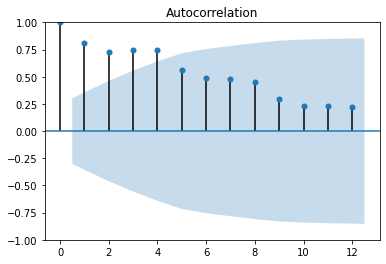

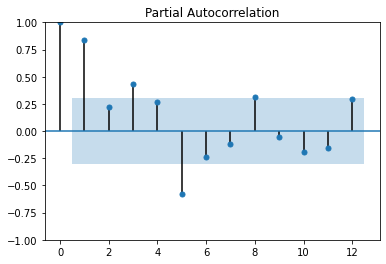

In [13]:
tsaplots.plot_acf(series.Sales,lags=12)
tsaplots.plot_pacf(series.Sales,lags=12)
plt.show()

**DATA PREPROCESSING**

In [14]:
series['quarter'] = 0
for i in range(42):
    p=series['Quarter'][i]
    series['quarter'][i]=p[0:2]

series.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Quarter,Sales,quarter
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [15]:
series['quarter'].value_counts()

Q1    11
Q2    11
Q3    10
Q4    10
Name: quarter, dtype: int64

In [16]:
df_dummies=pd.DataFrame(pd.get_dummies(series['quarter']),columns=['Q1','Q2','Q3','Q4'])
series_1=pd.concat([series,df_dummies],axis= 1)

In [17]:
series_1.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [18]:
series_1['t'] = np.arange(1,43)
series_1['t_squared'] = series_1['t']**2
series_1["Sales_log"] =np.log(series_1['Sales'])

In [19]:
series_1.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_squared,Sales_log
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602


**SPLITTING THE DATA**

In [20]:
train =series_1.head(32)
test =series_1.tail(10)

**MODELS**

In [21]:
# Linear Model
linear_model =smf.ols("Sales~t",data =train).fit()
linear_pred = pd.Series(linear_model.predict(test['t']))
linear_rmse =np.sqrt(mean_squared_error(np.array(test['Sales']),np.array(linear_pred)))
linear_rmse

752.9233932767116

In [22]:
#Exponential
Exp = smf.ols('Sales_log~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

590.3316432076487

In [23]:
#Quadratic Model
quad_model =smf.ols("Sales~t+t_squared",data=train).fit()
quad_pred = pd.Series(quad_model.predict(test[['t','t_squared']]))
quad_rmse =np.sqrt(mean_squared_error(np.array(test['Sales']),np.array(quad_pred)))
quad_rmse

457.735735540752

In [24]:
#Additive seasonality 
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1850.466546185835

In [25]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Q1','Q2','Q3','Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

277.351077112853

In [26]:
#Multiplicative Seasonality
Mul_sea = smf.ols('Sales_log~Q1+Q2+Q3+Q4',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1908.250394836115

In [27]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('Sales_log~t+Q1+Q2+Q3+Q4',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

448.8678182691809

In [28]:
# Exponential model
exp_model  =smf.ols("Sales_log~t",data=train).fit()
exp_pred =pd.Series(exp_model.predict(test['t']))
exp_rmse =np.sqrt(mean_squared_error(np.array(test['Sales']),np.array(exp_pred)))
exp_rmse

4387.940544839098

**Using ARIMA model**

In [29]:
data = pd.read_excel("/content/CocaCola_Sales_Rawdata (1).xlsx",header=0,index_col=0, parse_dates=True)
data.head()

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996


In [30]:
#separate out a validation dataset
split_point = len(data) - 7
dataset_cc, validation_cc = data[0:split_point], data[split_point:]
print('Dataset_cc %d, Validation_cc %d' % (len(dataset_cc), len(validation_cc)))

Dataset_cc 35, Validation_cc 7


In [31]:
dataset_cc.to_csv('dataset_cc.csv', header=False)
validation_cc.to_csv('validation_cc.csv', header=False)

In [32]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt

train = read_csv('dataset_cc.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

train

0
Q1_86    1734.827000
Q2_86    2244.960999
Q3_86    2533.804993
Q4_86    2154.962997
Q1_87    1547.818996
Q2_87    2104.411995
Q3_87    2014.362999
Q4_87    1991.746998
Q1_88    1869.049999
Q2_88    2313.631996
Q3_88    2128.320000
Q4_88    2026.828999
Q1_89    1910.603996
Q2_89    2331.164993
Q3_89    2206.549995
Q4_89    2173.967995
Q1_90    2148.278000
Q2_90    2739.307999
Q3_90    2792.753998
Q4_90    2556.009995
Q1_91    2480.973999
Q2_91    3039.522995
Q3_91    3172.115997
Q4_91    2879.000999
Q1_92    2772.000000
Q2_92    3550.000000
Q3_92    3508.000000
Q4_92    3243.859993
Q1_93    3056.000000
Q2_93    3899.000000
Q3_93    3629.000000
Q4_93    3373.000000
Q1_94    3352.000000
Q2_94    4342.000000
Q3_94    4461.000000
Name: 1, dtype: float64

In [33]:
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [34]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
>Predicted=3373.000, Expected=3352.000
>Predicted=3352.000, Expected=4342.000
>Predicted=4342.000, Expected=4461.000
RMSE: 434.401


**PERFORMING AUTO ARIMA**

We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not

In [37]:
from pmdarima.arima import ADFTest, auto_arima
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(data)
#From above we conclude that the data is stationary

(0.06309659985640072, True)

In [39]:
arima_model_1 = auto_arima(test)

In [41]:
arima_model_1.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [43]:
pred=arima_model_1.predict(n_periods=len(test))

In [44]:
from sklearn.metrics import mean_squared_error
rmse_autoarima=np.sqrt(mean_squared_error(test,pred))
rmse_autoarima

1247.5002674025172

**CHOOSING A MODEL**

In [46]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","rmse_arima","rmse_auto_arima"]),"RMSE_Values":pd.Series([linear_rmse,exp_rmse,quad_rmse,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea,rmse,rmse_autoarima])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,277.351077
7,rmse_arima,434.400665
6,rmse_Mult_add_sea,448.867818
2,rmse_quad,457.735736
0,rmse_linear,752.923393
8,rmse_auto_arima,1247.500267
3,rmse_add_sea,1850.466546
5,rmse_Mult_sea,1908.250395
1,rmse_exp,4387.940545


**Since Quadratic Additive Seasonality has the least rmse value, we stick to that model**

In [35]:
#Performing Prediction on the entire dataset
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=series_1).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(series_1[['Q1','Q2','Q3','Q4','t','t_squared']]))

In [39]:
series_1['Predicted_Sales']=add_sea_Quad.predict(series_1)
series_1

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_squared,Sales_log,Predicted,Predicted_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663,1626.592727,1626.592727
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443,2268.402339,2268.402339
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477,2189.685821,2189.685821
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529,1867.242917,1867.242917
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602,1658.311143,1658.311143
5,Q2_87,2104.411995,Q2,0,1,0,0,6,36,7.651791,2314.185178,2314.185178
6,Q3_87,2014.362999,Q3,0,0,1,0,7,49,7.608058,2249.533083,2249.533083
7,Q4_87,1991.746998,Q4,0,0,0,1,8,64,7.596767,1941.154603,1941.154603
8,Q1_88,1869.049999,Q1,1,0,0,0,9,81,7.533186,1746.287252,1746.287252
9,Q2_88,2313.631996,Q2,0,1,0,0,10,100,7.746574,2416.225709,2416.225709
